In [72]:
import os
import cv2
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [73]:
img_dir = '/kaggle/input/flickr8k/Images'
output_dir= '/kaggle/working'

In [ ]:

# load vgg16 model
weights = '/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg_model = VGG16(weights = weights)

#use last layer as output
model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

print(model.summary())

In [ ]:

img_features = {}
for img in tqdm(os.listdir(img_dir)):
    # loading the image from the file
    img_path = img_dir + '/' + img
    image = load_img(img_path, target_size=(224, 224))
    # convert images to array
    image = img_to_array(image)
    # expand the dimension
    image = np.expand_dims(image,axis = 0)
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_name = img.split('.')[0]
    # store feature
    img_features[image_name] = feature

In [ ]:
# store features in pickle
pickle.dump(img_features, open(os.path.join(output_dir, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join('/kaggle/input/image-features-vgg16', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
caption_path = '/kaggle/input/flickr8k/captions.txt'
with open(caption_path, 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
#all the images are mapped to its captions and seperated by \n
captions_doc[:600]

In [ ]:
# create mapping of image to captions
img_caption = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in img_caption:
        img_caption[image_id] = []
    # store the caption
    img_caption[image_id].append(caption)

In [ ]:
for img in img_caption:
    for cap in img_caption[img]:
        print(cap)
    img = img_dir + '/' + img + '.jpg'
    img = cv2.imread(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    break

In [ ]:
def clean(img_caption):
    for key, captions in img_caption.items():
        for i in range(len(captions)):
            cap = captions[i]
            #preprocessing text to get less vocabulary size
            cap = cap.lower()
            # delete digits, special chars, etc., 
            cap = cap.replace('[^A-Za-z]', '')
            # delete additional spaces
            cap = cap.replace('\s+', ' ')
            # add start and end tags to the caption
            cap = 'startofseq ' + " ".join([word for word in cap.split() if len(word)>1]) + ' endofseq'
            captions[i] = cap

In [ ]:
# before preprocess of text
img_caption['1000268201_693b08cb0e']

In [ ]:
# preprocess the text
clean(img_caption)

In [ ]:
# after preprocess of text
img_caption['1000268201_693b08cb0e']

In [ ]:
all_captions = []
for key in img_caption:
    for caption in img_caption[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)


In [ ]:
all_captions[:5]

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length


In [ ]:
image_ids = list(features.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
len(train)

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    n = 0
    while True:
        X1, X2, y = list(), list(), list()
        for key in data_keys[:100]:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
                    # Check if batch size is reached, then yield the data
                    if len(X1) == batch_size:
                        yield [np.array(X1), np.array(X2)], np.array(y)
                        X1, X2, y = list(), list(), list()


In [ ]:
train_data= data_generator(train,img_caption ,features, tokenizer, max_length, vocab_size,32)

In [ ]:
for x1,x2 in train_data:
    print(x1[0].shape,x1[1].shape,x2.shape)
    break

In [74]:
from tensorflow.keras.layers import concatenate,Attention,BatchNormalization,GRU
import tensorflow as tf

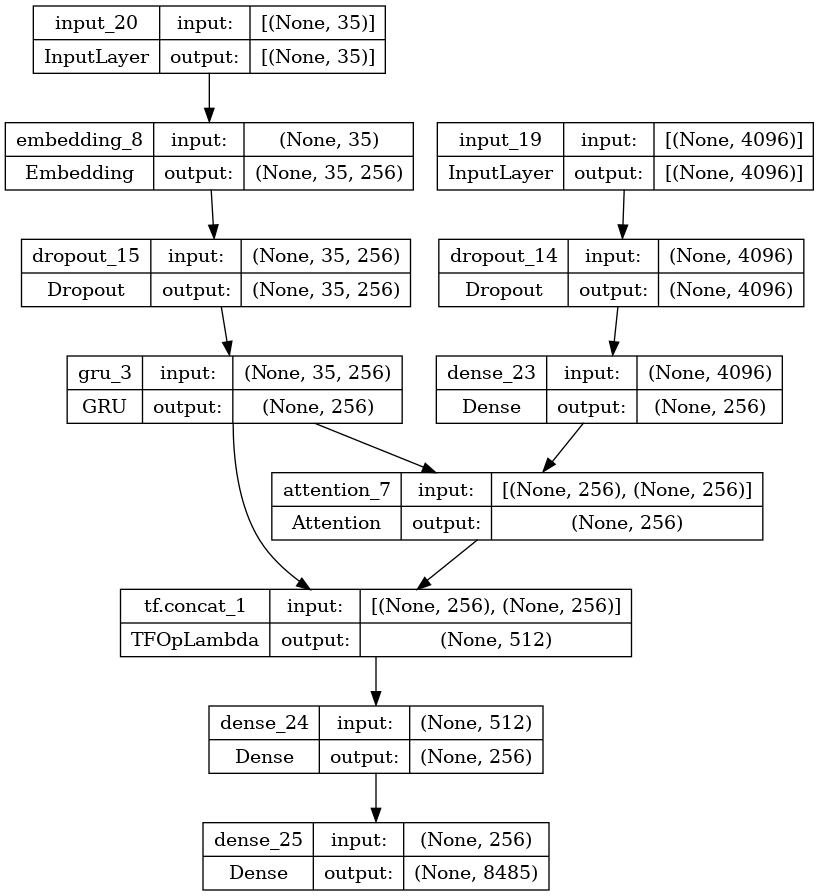

In [96]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)
attention_layer = Attention()([se3,fe2])
# decoder model
decoder1 = tf.concat([se3,attention_layer],axis = -1)
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [78]:
import tensorflow as tf

# List all available physical devices
physical_devices = tf.config.experimental.list_physical_devices()

for device in physical_devices:
    print(f"Device name: {device.name}, Device type: {device.device_type}")


Device name: /physical_device:CPU:0, Device type: CPU
Device name: /physical_device:GPU:0, Device type: GPU


In [ ]:
# Set a specific GPU as visible (assuming you have at least one GPU)
gpu_index = 0  # Replace with the GPU index you want to use
tf.config.experimental.set_visible_devices(physical_devices[gpu_index], 'GPU')


In [97]:
# train the model
epochs = 40
batch_size = 32
steps = len(train) // batch_size
for i in range(epochs):
    # create data generator
    generator = data_generator(train, img_caption, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 25s 108ms/step - loss: 0.5287


In [98]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [99]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startofseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endofseq':
            break
      
    return in_text

In [100]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/kaggle/input/flickr8k', "Images", image_name)
    image = Image.open(img_path)
    captions = img_caption[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startofseq black dog and spotted dog are fighting endofseq
startofseq black dog and tri-colored dog playing with each other on the road endofseq
startofseq black dog and white dog with brown spots are staring at each other in the street endofseq
startofseq two dogs of different breeds looking at each other on the road endofseq
startofseq two dogs on pavement moving toward each other endofseq
--------------------Predicted--------------------
startofseq man and white dogs are playing with its hill endofseq


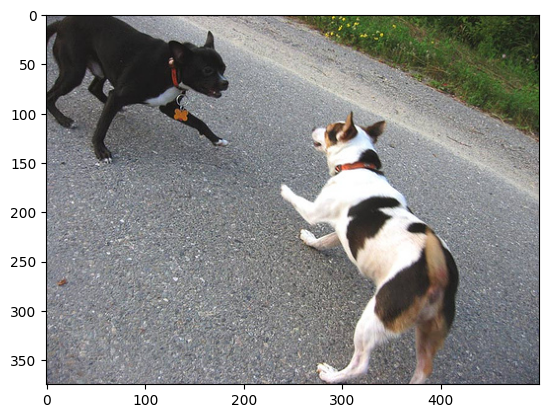

In [101]:
generate_caption("1001773457_577c3a7d70.jpg")

In [92]:
img_caption

{'1000268201_693b08cb0e': ['startofseq child in pink dress is climbing up set of stairs in an entry way endofseq',
  'startofseq girl going into wooden building endofseq',
  'startofseq little girl climbing into wooden playhouse endofseq',
  'startofseq little girl climbing the stairs to her playhouse endofseq',
  'startofseq little girl in pink dress going into wooden cabin endofseq'],
 '1001773457_577c3a7d70': ['startofseq black dog and spotted dog are fighting endofseq',
  'startofseq black dog and tri-colored dog playing with each other on the road endofseq',
  'startofseq black dog and white dog with brown spots are staring at each other in the street endofseq',
  'startofseq two dogs of different breeds looking at each other on the road endofseq',
  'startofseq two dogs on pavement moving toward each other endofseq'],
 '1002674143_1b742ab4b8': ['startofseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endofseq',
  'startofseq little girl is 

---------------------Actual---------------------
startofseq black dog leaps over log endofseq
startofseq grey dog is leaping over fallen tree endofseq
startofseq large black dog leaps fallen log endofseq
startofseq mottled black and grey dog in blue collar jumping over fallen tree endofseq
startofseq the black dog jumped the tree stump endofseq
--------------------Predicted--------------------
startofseq brown dog is running fast walking fast next to the side of the toy endofseq


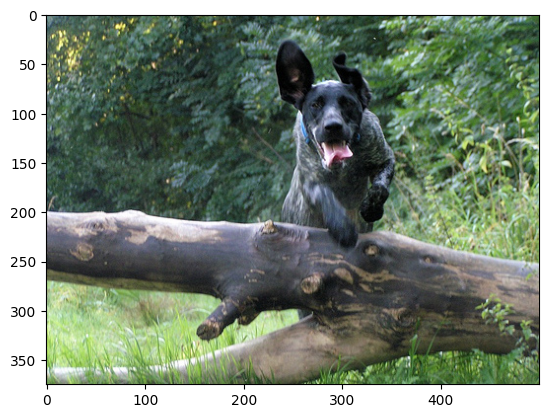

In [102]:
generate_caption("1015584366_dfcec3c85a.jpg")

In [103]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = img_caption[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.426458
BLEU-2: 0.180645
